Data cleaning and Pre Processing with Scaling and Saving of Preprocessing steps for Future Application Building

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib

# Load the dataset
df = pd.read_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Structured_Format.csv", low_memory=False)

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Helper function to convert price from various formats to float
def convert_price(price):
    try:
        price = str(price).replace('₹', '').replace(',', '').strip()
        if 'Lakh' in price:
            return float(price.replace('Lakh', '').strip()) * 100000
        else:
            return float(price)
    except ValueError:
        return np.nan

# Apply conversion function to the 'price' column
df['price'] = df['price'].apply(convert_price)

# Clean the 'km' column by removing commas and converting to integers
df['km'] = df['km'].str.replace('Kms', '').str.replace(',', '').astype(float)

# Fill missing values for numerical columns
df.fillna({
    'price': df['price'].median(),
    'ownerNo': df['ownerNo'].median(),
    'km': df['km'].median()
}, inplace=True)

# Remove the 'owner' column since it's the same as 'ownerNo'
df.drop(columns=['owner'], inplace=True)

# Clean and extract mileage from 'top_0_value.2' column and rename the column
def clean_mileage(mileage):
    try:
        mileage = str(mileage).replace('kmpl', '').replace('km/kg', '').strip()
        mileage_float = float(mileage)
        if mileage_float < 100:  # Assuming mileage values should be less than 100
            return mileage_float
        else:
            return np.nan
    except ValueError:
        return np.nan

df['mileage'] = df['top_0_value.2'].apply(clean_mileage)

# Clean and extract seats from 'top_3_value' column and rename the column
def clean_seats(seats):
    try:
        seats = str(seats).replace('Seats', '').strip()
        seats_int = int(seats)
        if seats_int < 10:  # Assuming seat values should be less than 10
            return seats_int
        else:
            return np.nan
    except ValueError:
        return np.nan

df['Seats'] = df['top_3_value'].apply(clean_seats)

# Drop the original columns 'top_0_value.2' and 'top_3_value'
df.drop(['top_0_value.2', 'top_3_value'], axis=1, inplace=True)

# Label Encoding for categorical variables
label_encoders = {}
def label_encode(df, columns):
    global label_encoders
    for col in columns:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    return df

categorical_columns = ['ft', 'bt', 'transmission', 'oem', 'model', 'variantName', 'City']
df = label_encode(df, categorical_columns)

# Normalizing numerical features using Min-Max Scaling, excluding 'price'
scalers = {}
def min_max_scaling(df, columns):
    global scalers
    for col in columns:
        if col in df.columns:
            scaler = MinMaxScaler()
            df[col] = scaler.fit_transform(df[[col]])
            scalers[col] = scaler
    return df

df = min_max_scaling(df, ['km', 'modelYear', 'ownerNo', 'mileage', 'Seats'])

# Removing outliers using IQR for 'price'
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

# Save the cleaned data
df.to_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Cleaned_Dataset.csv", index=False)

# Save preprocessing steps
joblib.dump(label_encoders,"C:/Users/nandh/OneDrive/Desktop/cardheko/Label_Encoders.pkl")
joblib.dump(scalers, "C:/Users/nandh/OneDrive/Desktop/cardheko/Scalers.pkl")

print("Data cleaning complete, Cleaned dataset saved as 'car_dekho_cleaned_dataset.csv'.")
print("Preprocessing steps saved.")

Data cleaning complete, Cleaned dataset saved as 'car_dekho_cleaned_dataset.csv'.
Preprocessing steps saved.


Exploratory Data Analysis: Plots

C:\Users\nandh\AppData\Local\Temp\ipykernel_17296\1997700571.py:7: DtypeWarning: Columns (155) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scaled = pd.read_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Cleaned_Dataset.csv")


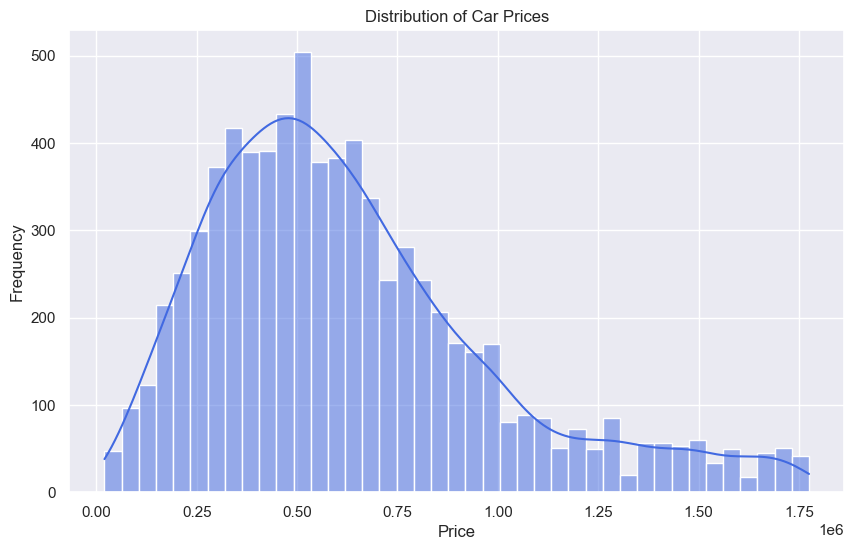

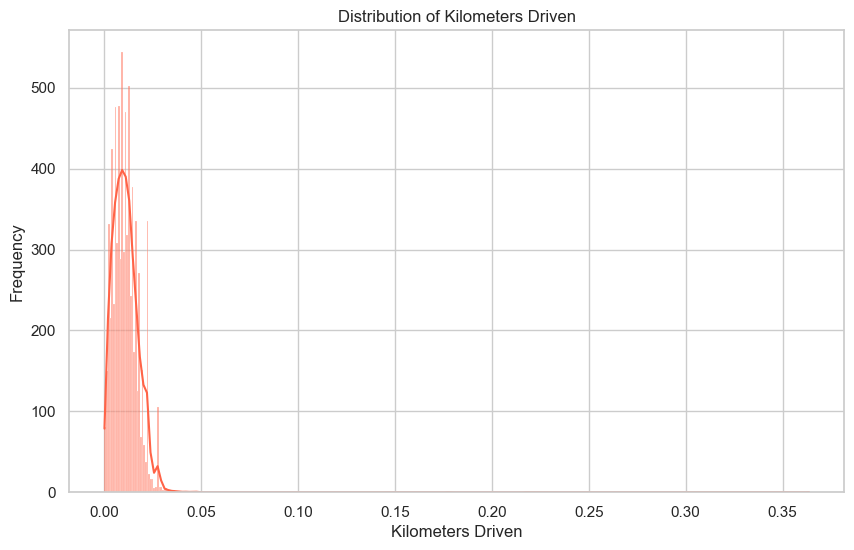

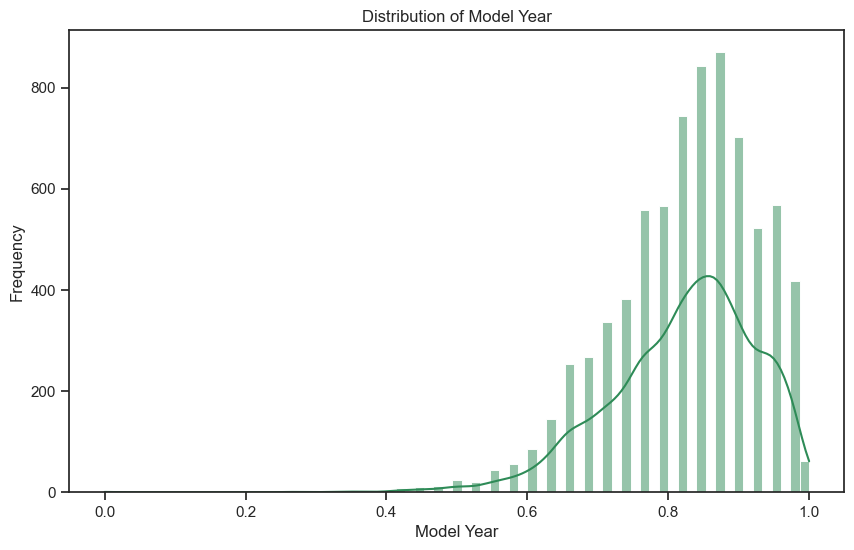

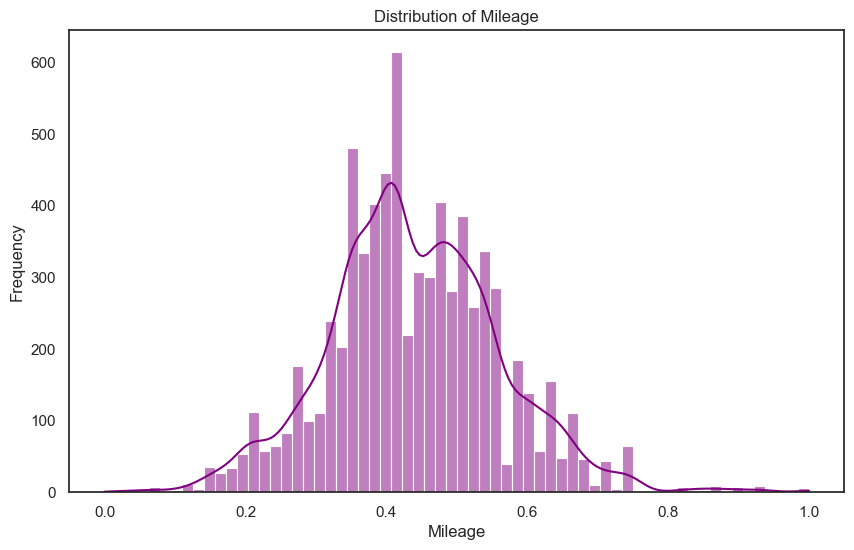

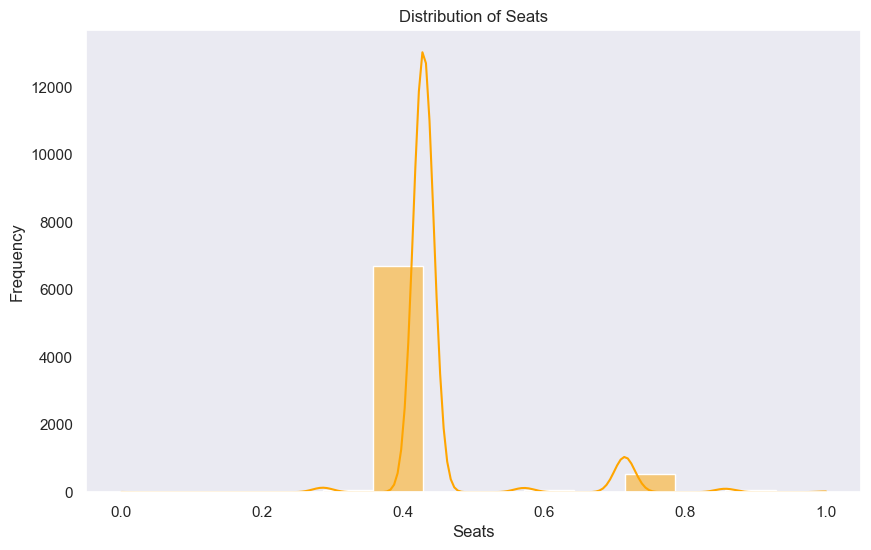

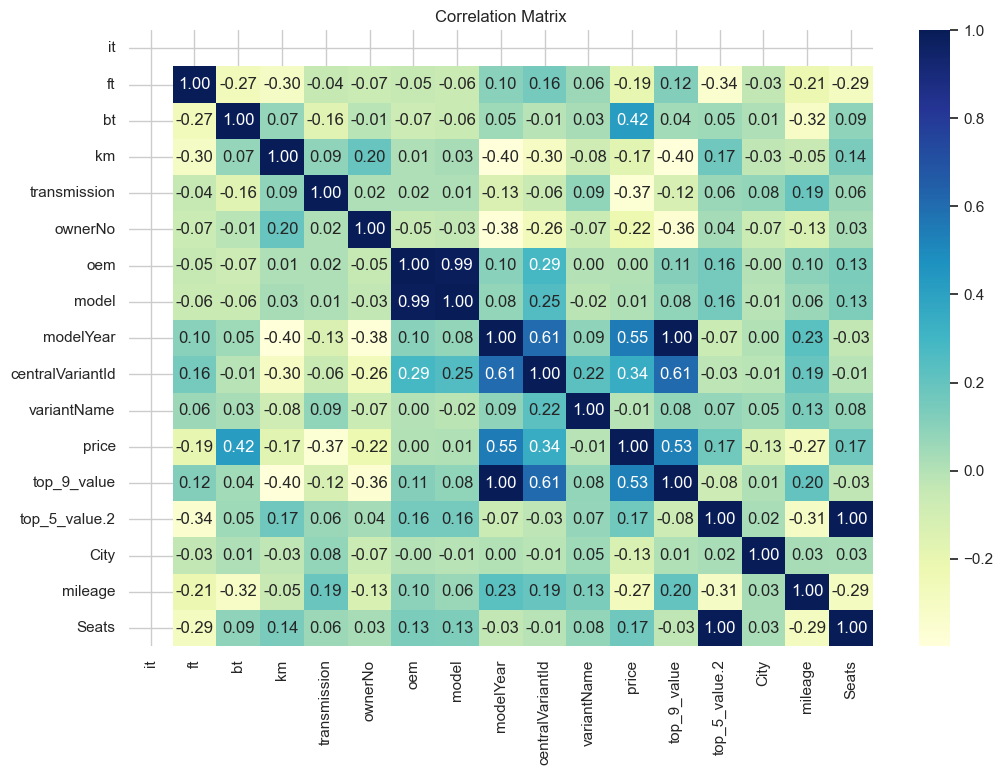

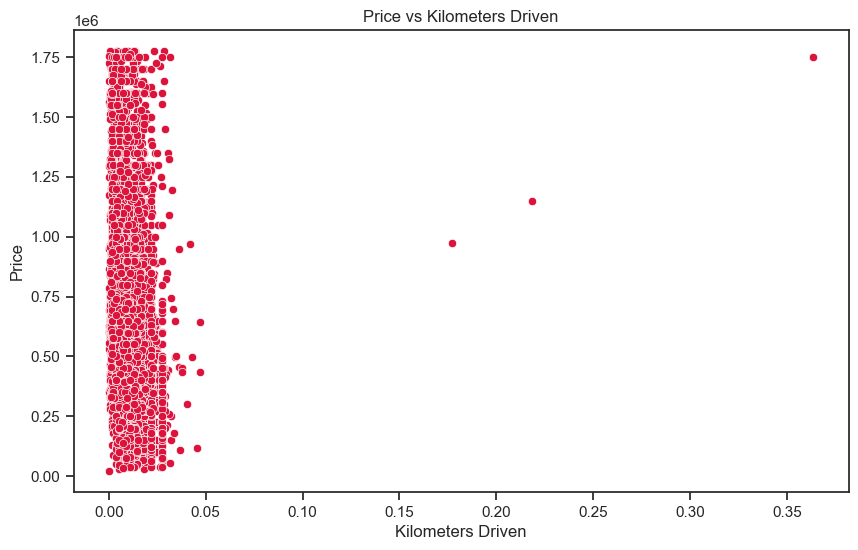

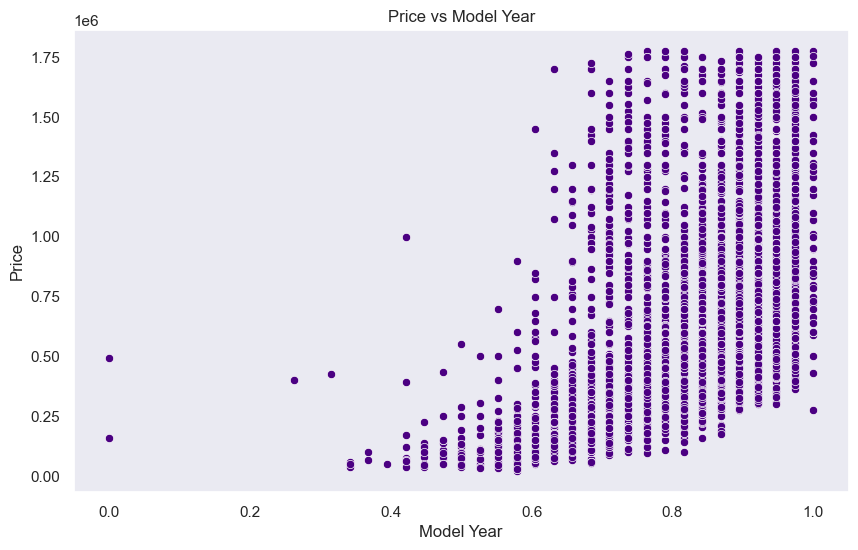

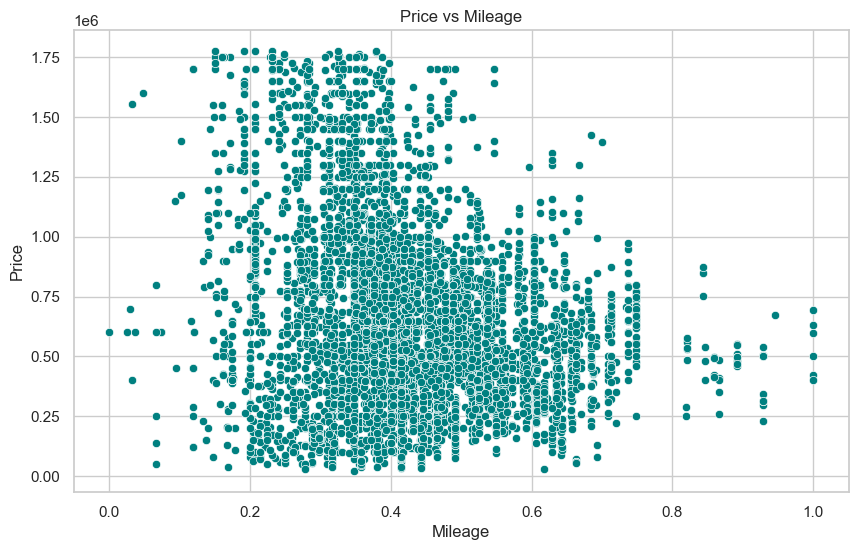

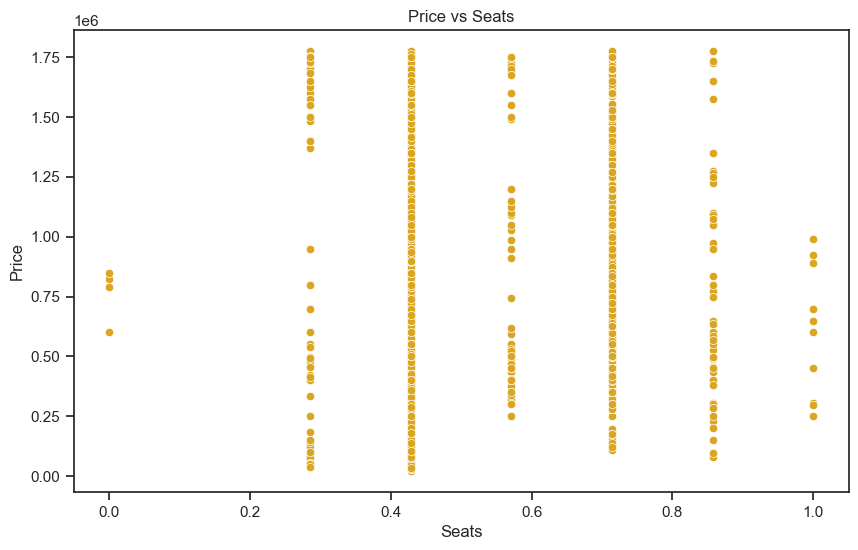

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned dataset with scaling
df_scaled = pd.read_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Cleaned_Dataset.csv")

# Distribution Plot for Price
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.histplot(df_scaled['price'], kde=True, color='royalblue')
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Distribution Plot for Kilometers Driven
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.histplot(df_scaled['km'], kde=True, color='tomato')
plt.title('Distribution of Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Frequency')
plt.show()

# Distribution Plot for Model Year
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.histplot(df_scaled['modelYear'], kde=True, color='seagreen')
plt.title('Distribution of Model Year')
plt.xlabel('Model Year')
plt.ylabel('Frequency')
plt.show()

# Distribution Plot for Mileage
plt.figure(figsize=(10, 6))
sns.set_style("white")
sns.histplot(df_scaled['mileage'], kde=True, color='purple')
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

# Distribution Plot for Seats
plt.figure(figsize=(10, 6))
sns.set_style("dark")
sns.histplot(df_scaled['Seats'], kde=True, color='orange')
plt.title('Distribution of Seats')
plt.xlabel('Seats')
plt.ylabel('Frequency')
plt.show()

# Select only numeric columns
df_numeric = df_scaled.select_dtypes(include=[np.number])

# Correlation Matrix for the scaled data with a different color palette
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.heatmap(df_numeric.corr(), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# Scatter Plot of Price vs Kilometers Driven
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.scatterplot(x='km', y='price', data=df_scaled, color='crimson')
plt.title('Price vs Kilometers Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.show()

# Scatter Plot of Price vs Model Year
plt.figure(figsize=(10, 6))
sns.set_style("dark")
sns.scatterplot(x='modelYear', y='price', data=df_scaled, color='indigo')
plt.title('Price vs Model Year')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.show()

# Scatter Plot of Price vs Mileage
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.scatterplot(x='mileage', y='price', data=df_scaled, color='teal')
plt.title('Price vs Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

# Scatter Plot of Price vs Seats
plt.figure(figsize=(10, 6))
sns.set_style("ticks")
sns.scatterplot(x='Seats', y='price', data=df_scaled, color='goldenrod')
plt.title('Price vs Seats')
plt.xlabel('Seats')
plt.ylabel('Price')
plt.show()


In [12]:
def plot_boxplot_price(df_scaled):
    plt.figure(figsize=(10, 4), layout='constrained')
    sns.set_style('darkgrid')  # Change style
    sns.boxplot(y=df['price'], color='skyblue')  # New color
    plt.title('Box Plot of Car Prices', fontsize=16)
    plt.ylabel('Price', fontsize=14)
    plt.show()

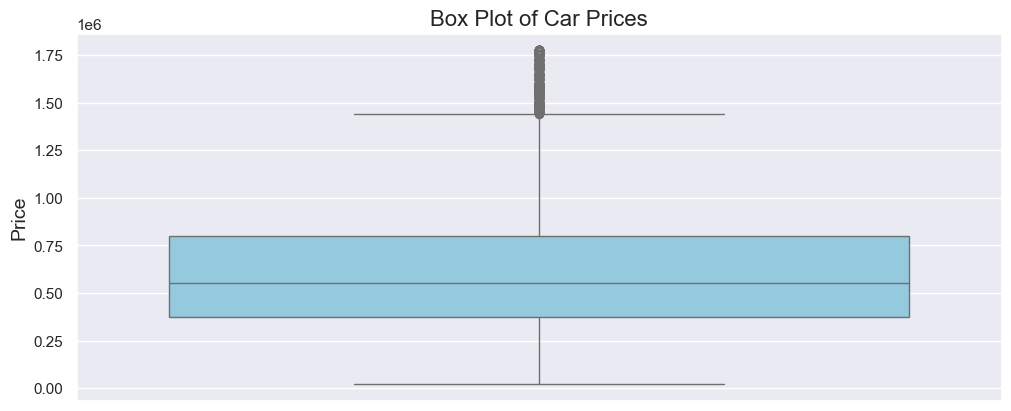

In [13]:
# Plot box plot for 'price'
plot_boxplot_price(df)

Data Cleaning Without Scaling and Ecoding (For Future Use)

In [11]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Structured_Format.csv", low_memory=False)

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# Helper function to convert price from various formats to float
def convert_price(price):
    try:
        price = str(price).replace('₹', '').replace(',', '').strip()
        if 'Lakh' in price:
            return float(price.replace('Lakh', '').strip()) * 100000
        else:
            return float(price)
    except ValueError:
        return np.nan

# Apply conversion function to the 'price' column
df['price'] = df['price'].apply(convert_price)

# Clean the 'km' column by removing commas and converting to integers
df['km'] = df['km'].str.replace('Kms', '').str.replace(',', '').astype(float)

# Fill missing values for numerical columns
df.fillna({
    'price': df['price'].median(),
    'ownerNo': df['ownerNo'].median(),
    'km': df['km'].median()
}, inplace=True)

# Remove the 'owner' column since it's the same as 'ownerNo'
df.drop(columns=['owner'], inplace=True)

# Clean and extract mileage from 'top_0_value.2' column and rename the column
def clean_mileage(mileage):
    try:
        mileage = str(mileage).replace('kmpl', '').replace('km/kg', '').strip()
        mileage_float = float(mileage)
        if mileage_float < 100:  # Assuming mileage values should be less than 100
            return mileage_float
        else:
            return np.nan
    except ValueError:
        return np.nan

df['mileage'] = df['top_0_value.2'].apply(clean_mileage)

# Clean and extract seats from 'top_3_value' column and rename the column
def clean_seats(seats):
    try:
        seats = str(seats).replace('Seats', '').strip()
        seats_int = int(seats)
        if seats_int < 10:  # Assuming seat values should be less than 10
            return seats_int
        else:
            return np.nan
    except ValueError:
        return np.nan

df['Seats'] = df['top_3_value'].apply(clean_seats)

# Drop the original columns 'top_0_value.2' and 'top_3_value'
df.drop(['top_0_value.2', 'top_3_value'], axis=1, inplace=True)

# Removing outliers using IQR for 'price'
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

# Save the cleaned data
df.to_csv("C:/Users/nandh/OneDrive/Desktop/cardheko/Car_Dekho_Cleaned_Dataset_Raw.csv", index=False)

print("Data cleaning complete. Cleaned dataset saved as 'car_dekho_cleaned_dataset_Raw.csv'.")

Data cleaning complete. Cleaned dataset saved as 'car_dekho_cleaned_dataset_Raw.csv'.
